In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
database_path = "Resources/hawaii.sqlite"
engine = sqlalchemy.create_engine(f"sqlite:///{database_path}")

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
Base = automap_base()
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Map Measurement and Station tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Import datetime module
import datetime as dt

In [9]:
# Save latest date into a variable and in string type
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

In [10]:
# Find the latest year
date_time_obj = dt.datetime.strptime(latest_date, '%Y-%m-%d') # %H:%M:%S.%f
date_time_obj.year

2017

In [11]:
# Last year from latest date's year
one_year_back = date_time_obj.year - 1
one_year_back

2016

In [12]:
# Reconstruct the date 12 months back from the latest available date
latest_twelve_months_date = dt.date(one_year_back, date_time_obj.month, date_time_obj.day)
latest_twelve_months_date

datetime.date(2016, 8, 23)

In [13]:
# Check which columns does the Measurement table has
# Try with inspect module
from sqlalchemy import inspect

In [14]:
# Use inspect to create an object to check the columns' names
inst = inspect(Measurement)
inst

<Mapper at 0x7fde78eefd30; measurement>

In [15]:
# Get columns' names from Measurement table using mapper method on inst object
attr_names = [c_attr.key for c_attr in inst.mapper.column_attrs]
attr_names

['id', 'station', 'date', 'prcp', 'tobs']

In [16]:
# Try getting columns with reflect module
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Meas = Base.classes.measurement
Sta = Base.classes.station

In [17]:
# Use the session to query Meas table and display the first 5 entries
for row in session.query(Meas.id, Meas.station, Meas.date, Meas.prcp, Meas.tobs).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.date <= latest_date).\
    limit(5).all():
    print(row)

(2365, 'USC00519397', '2016-08-24', 0.08, 79.0)
(2366, 'USC00519397', '2016-08-25', 0.08, 80.0)
(2367, 'USC00519397', '2016-08-26', 0.0, 79.0)
(2368, 'USC00519397', '2016-08-27', 0.0, 77.0)
(2369, 'USC00519397', '2016-08-28', 0.01, 78.0)


In [18]:
# Check count before and after filtering precipitation 'None'
prcp_list = []
date_list = []
for row in session.query(Meas.date, Meas.prcp).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all():
    prcp_list.append(row[1])
    date_list.append(row[0])
    #print(f"Date: {row[0]}, precipitation {row[1]}")
len(prcp_list)
print(f"There are {len(prcp_list)} entries including precipitation 'None' values.")    

There are 2015 entries including precipitation 'None' values.


In [19]:
# Convert date list into datetime format for easier handling of plotting
date_list_datetime = pd.to_datetime(date_list)
date_list_datetime

DatetimeIndex(['2017-08-23', '2017-08-23', '2017-08-23', '2017-08-23',
               '2017-08-22', '2017-08-22', '2017-08-22', '2017-08-21',
               '2017-08-21', '2017-08-21',
               ...
               '2016-08-25', '2016-08-25', '2016-08-25', '2016-08-25',
               '2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24',
               '2016-08-24', '2016-08-24'],
              dtype='datetime64[ns]', length=2015, freq=None)

In [20]:
# Save precipitation and date into variables using list comprehension
prcp = [row[1] for row in session.query(Meas.date, Meas.prcp).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all()]
date = [row[0] for row in session.query(Meas.date, Meas.prcp).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all()]

In [21]:
# # Create Precipitation dataframe to explore plotting options easier
# prcp_df = pd.DataFrame({'Date': date, 'Precipitation': prcp})
# prcp_df.head()

In [22]:
# Create Precipitation dataframe to explore plotting options easier
prcp_df = pd.DataFrame({'Date': date_list_datetime, 'Precipitation': prcp_list})
prcp_df.head()

,Date,Precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


In [23]:
type(prcp_df['Date'][0]) # datetime type

pandas._libs.tslibs.timestamps.Timestamp

In [24]:
# Check if grouped by day give 1 year equivalent - 365
grouped_prcp = [row[1] for row in session.query(Meas.date, Meas.prcp).group_by(Meas.date).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all()]
grouped_date = [row[0] for row in session.query(Meas.date, Meas.prcp).group_by(Meas.date).\
    order_by(Measurement.date.desc()).\
    filter(Meas.date <= latest_date).\
    filter(Meas.date > latest_twelve_months_date).\
    filter(Meas.prcp != 'None').\
    all()]
print(f"There are {len(grouped_date)} entries when group by date, as expected for the latest 12 months.")

There are 365 entries when group by date, as expected for the latest 12 months.


In [25]:
# Create dataframe from the grouped lists for comparison
prcp_grouped_df = pd.DataFrame({'Date': grouped_date, 'Precipitation': grouped_prcp})
len(prcp_grouped_df)

365

In [26]:
#  Check the dataframe columns and their data types
prcp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2015 entries, 0 to 2014
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2015 non-null   datetime64[ns]
 1   Precipitation  2015 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.6 KB


In [27]:
# Use resample method on the Date column to sum grouped by date 'M' month
prcp = prcp_df.set_index('Date').resample('M')["Precipitation"].sum()

In [28]:
# Create data frame from the pandas series above
type(prcp)

pandas.core.series.Series

Text(0, 0.5, 'Accumulated Precipitation')

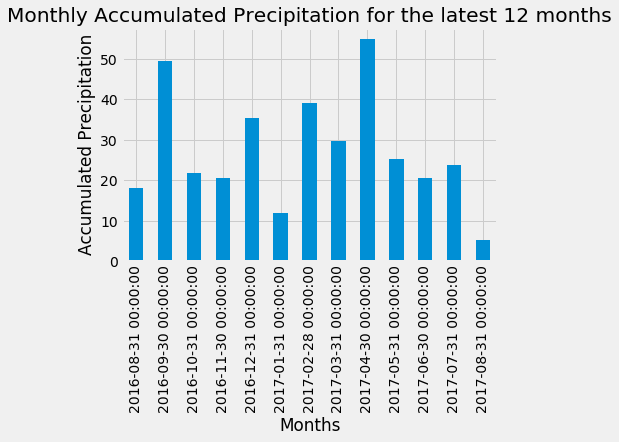

In [29]:
prcp.plot(kind='bar')
plt.title("Monthly Accumulated Precipitation for the latest 12 months")
plt.xlabel("Months")
plt.ylabel("Accumulated Precipitation")

In [30]:
prcp_reset = prcp.reset_index()
prcp_reset

,Date,Precipitation
0,2016-08-31,18.10
1,2016-09-30,49.40
2,2016-10-31,21.77
3,2016-11-30,20.56
4,2016-12-31,35.51
5,2017-01-31,11.95
6,2017-02-28,39.06
7,2017-03-31,29.62
8,2017-04-30,54.91
9,2017-05-31,25.27


In [31]:
type(prcp_reset)

pandas.core.frame.DataFrame

(array([736208., 736269., 736330., 736389., 736450., 736511., 736573.]),
 <a list of 7 Text xticklabel objects>)

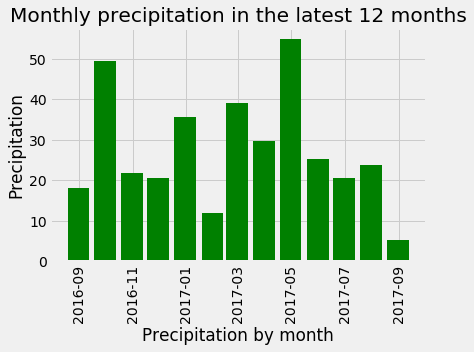

In [43]:
# Plot precipitation using plt.plot() method
x_axis = prcp_reset['Date']
y_axis = prcp_reset['Precipitation']
plt.bar(x_axis, y_axis, color='g', width=25, align="center")
plt.title("Monthly precipitation in the latest 12 months")
plt.xlabel("Precipitation by month")
plt.ylabel("Precipitation")
plt.xticks(rotation='vertical')

## Bonus Challenge Assignment

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [36]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [38]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [39]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [40]:
# Plot the daily normals as an area plot with `stacked=False`
